In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [5]:
# 데이터 로드
df = pd.read_csv('./data/gym_churn_us.csv')
df.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

## XGBoost 최적의 파라미터 찾아보기

In [6]:
# 1. 데이터 로드 완료

# 2. 데이터 전처리

# 이진으로 분류된 데이터를 제외하고 범주형 데이터를 위한 전처리
columns = ['Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']
scaler = StandardScaler()
df[columns] =scaler.fit_transform(df[columns])

# 3. 데이터 분리
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 모델 적용 및 평가
# 4-2. XGBoost 모델 
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# 평가 함수
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} 모델 성능 평가")
    print("accuracy_score", accuracy_score(y_test, y_pred))
    print("precision:", precision_score(y_test, y_pred))
    print(f'f1_score: {f1_score(y_test, y_pred)}')


# 모델 성능 평가
evaluate_model(y_test, y_pred_xgb, 'XGBoost')
# print(classification_report(y_test, y_pred_xgb))


XGBoost 모델 성능 평가
accuracy_score 0.9275
precision: 0.8829787234042553
f1_score: 0.8512820512820513


c:\Users\Playdata\anaconda3\envs\pystudy_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## XGBoost 최적의 파라미터 찾아보기

In [7]:
from sklearn.model_selection import GridSearchCV

# XGBoost 모델 객체 생성
xgb = XGBClassifier(eval_metric='logloss', enable_categorical=False)

# 하이퍼파라미터 후보 설정
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# GridSearchCV 실행
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델로 예측
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
y_pred_proba_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

# 성능 평가
evaluate_model(y_test, y_pred_best_xgb, 'XGB')


Fitting 3 folds for each of 108 candidates, totalling 324 fits
최적의 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}

XGB 모델 성능 평가
accuracy_score 0.93375
precision: 0.9027027027027027
f1_score: 0.8630490956072352


### 결론
- 최적의 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
- 성능 향상
    - accuracy_score 0.93375
    - precision: 0.9027027027027027
    - f1_score: 0.8630490956072352

- 이전 결과
    - accuracy_score 0.9275
    - precision: 0.8829787234042553
    - f1_score: 0.8512820512820513

### 이전 결과에 비해 점수 모두 소폭 상승

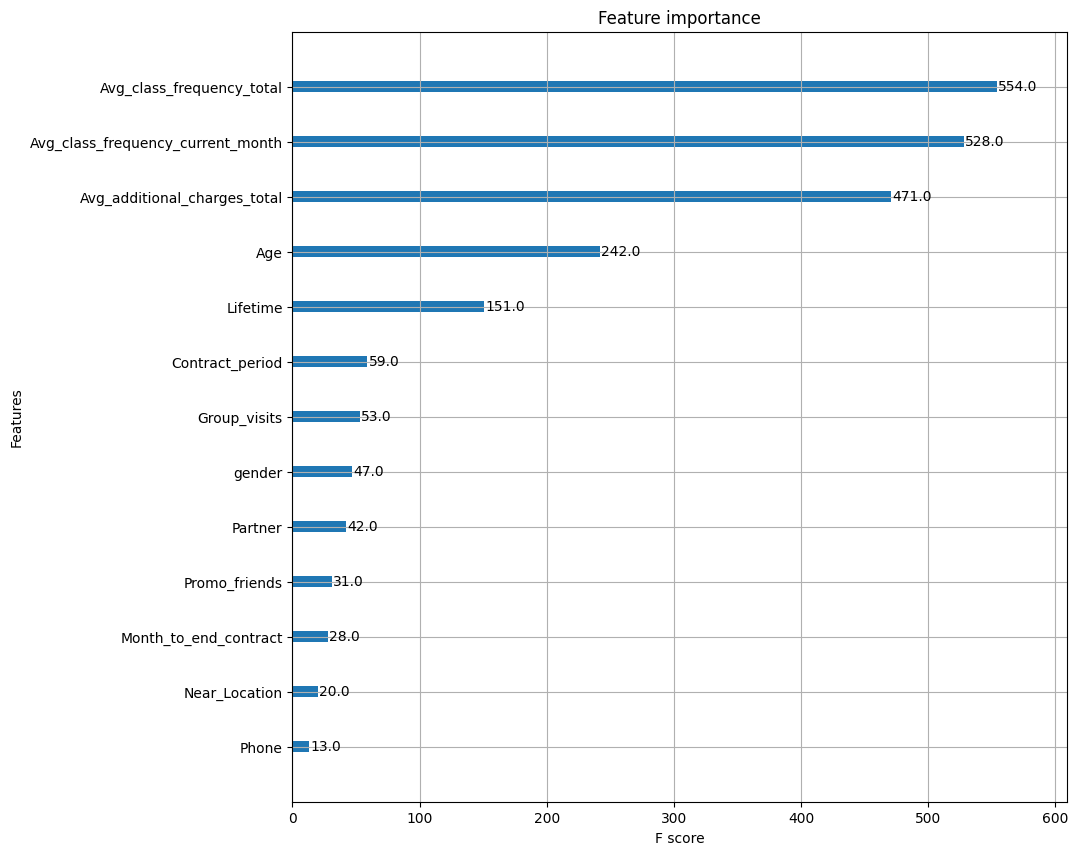

In [8]:
# 특성 중요도 시각화
from xgboost import plot_importance
xgb.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(xgb, ax =ax) 
plt.show()   

## ROC_auc Score 적용 및 시각화

In [9]:
from sklearn.metrics import roc_auc_score

# 모델 성능 평가
# XGBoost Model - Best params 적용 전
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_proba = xgb.predict_proba(X_test)[:, 1]


print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_xgb_proba))  
  

# 적용 후
y_pred_best_xgb = best_xgb.predict(X_test)
y_pred_proba_best_xgb = best_xgb.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_best_xgb))


ROC-AUC Score: 0.9695685287592304
ROC-AUC Score: 0.9774495844233252


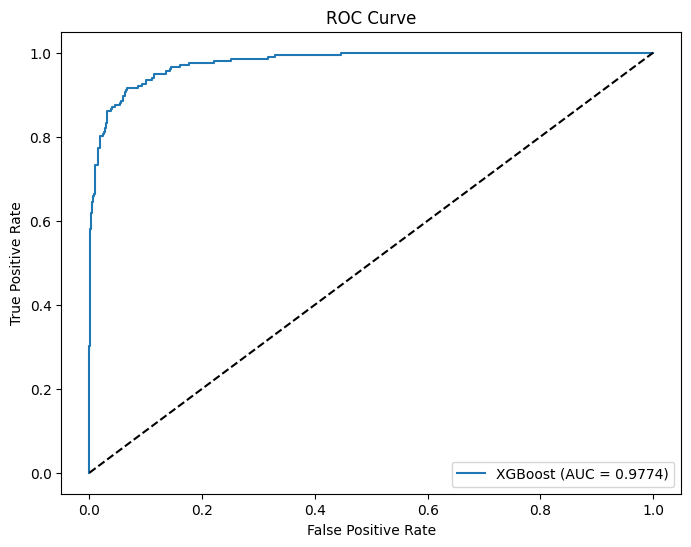

In [10]:
# Roc_auc 평가 확인
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Roc_curve 시각화
def plot_roc_curve(y_true, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_proba):.4f})')
    
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_pred_proba_best_xgb, "XGBoost")

# 대각선 기준선 (무작위 예측)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 최종 결론

1.모델 사용 
 Logistic < XGBoost 결과가 조금 더 좋은 편

2. GridsearchCV & RandomSerchCV  사용해서 최적의 파라미터 찾고 모델에 적용 및 점수 비교
- XGBoost의 경우
    - 최적의 파라미터로 모델을 실행했을 때, accuracy, precision, f1 score , Roc_Auc 점수 모두 0.01이상 증가함 (큰 차이는 X)
    - feature_importance에서 수업 참여 빈도 -> 추가 지출 비용 -> 나이 순으로 중요도가 높았다.

4. Roc_Auc Score
- 시각화해놓은 ROC_curve에서 쉽게 확인할 수 있듯이
-  0.9774로 높은 점수를 내고 있다!
